In [17]:
# Multi-server vs Single-server M/M/c queue simulation with shared finite buffer
# Compared with the simpler single-server (M/M/1) setup in Task 1

import random
from queue import PriorityQueue
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# ---------------------------- Configuration ----------------------------
ARRIVAL = 5.0          # Average inter-arrival time (lambda = 0.2)
SIM_TIME = 100000      # Total simulation time per run
SERVICE_TIME = 5.0     # Mean service time (mu = 0.2)
BUFFER_SIZE = 10       # Finite buffer size (shared among servers)
REPEATS = 30           # Repetitions for averaging results

In [9]:
# Measurement container
class Measure:
    def __init__(self):
        self.arr = 0
        self.dep = 0
        self.ut = 0.0
        self.oldT = 0.0
        self.delay = 0.0
        self.loss = 0

In [10]:
# Client structure
class Client:
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time

In [11]:
# Event functions

def arrival(time, FES, queue, data, servers, buffer_size):
    data.arr += 1
    data.ut += len(queue) * (time - data.oldT)
    data.oldT = time

    inter_arrival = random.expovariate(1.0 / ARRIVAL)
    FES.put((time + inter_arrival, "arrival"))

    free_server = next((i for i, busy in enumerate(servers) if not busy), None)

    if free_server is not None:
        servers[free_server] = True
        service_time = random.expovariate(1.0 / SERVICE_TIME)
        FES.put((time + service_time, f"departure_{free_server}"))
    elif len(queue) < buffer_size:
        queue.append(Client(time))
    else:
        data.loss += 1

In [12]:
def departure(time, FES, queue, data, servers, server_id):
    data.dep += 1
    data.ut += len(queue) * (time - data.oldT)
    data.oldT = time

    if queue:
        client = queue.pop(0)
        data.delay += (time - client.arrival_time)
        service_time = random.expovariate(1.0 / SERVICE_TIME)
        FES.put((time + service_time, f"departure_{server_id}"))
    else:
        servers[server_id] = False


In [18]:
# Simulation wrapper

def run_simulation(num_servers, buffer_size):
    global ARRIVAL, SERVICE_TIME, SIM_TIME

    FES = PriorityQueue()
    queue = []
    servers = [False] * num_servers
    data = Measure()

    FES.put((0, "arrival"))
    time = 0

    while time < SIM_TIME:
        time, event_type = FES.get()

        if event_type == "arrival":
            arrival(time, FES, queue, data, servers, buffer_size)

        elif event_type.startswith("departure"):
            server_id = int(event_type.split("_")[1])
            departure(time, FES, queue, data, servers, server_id)

    delay = data.delay / data.dep if data.dep > 0 else 0
    loss_rate = data.loss / data.arr if data.arr > 0 else 0
    avg_packets = data.ut / time
    utilization = sum([1 for busy in servers if busy]) / num_servers

    return {
        "arrivals": data.arr,
        "departures": data.dep,
        "loss_rate": loss_rate,
        "avg_delay": delay,
        "avg_packets": avg_packets,
        "utilization": utilization
    }


In [19]:
# Run simulations

def average_results(results):
    keys = results[0].keys()
    return {k: sum(r[k] for r in results) / len(results) for k in keys}

single_results = [run_simulation(1, float('inf')) for _ in range(REPEATS)]
multi_results  = [run_simulation(2, BUFFER_SIZE) for _ in range(REPEATS)]

single_avg = average_results(single_results)
multi_avg  = average_results(multi_results)


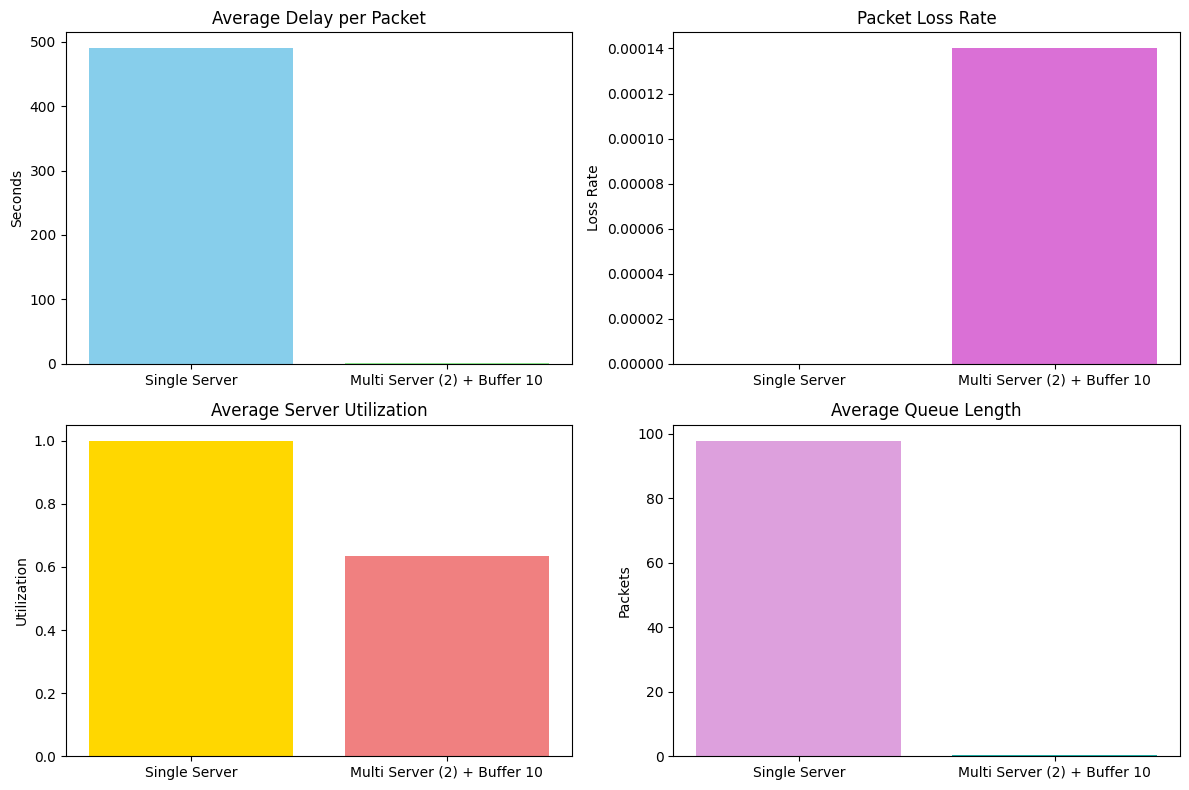

In [20]:
# Display comparison
systems = ["Single Server", "Multi Server (2) + Buffer 10"]

avg_delay = [single_avg["avg_delay"], multi_avg["avg_delay"]]
loss_rate = [single_avg["loss_rate"], multi_avg["loss_rate"]]
utilization = [single_avg["utilization"], multi_avg["utilization"]]
avg_packets = [single_avg["avg_packets"], multi_avg["avg_packets"]]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].bar(systems, avg_delay, color=['skyblue', 'lightgreen'])
axs[0, 0].set_title('Average Delay per Packet')
axs[0, 0].set_ylabel('Seconds')

axs[0, 1].bar(systems, loss_rate, color=['salmon', 'orchid'])
axs[0, 1].set_title('Packet Loss Rate')
axs[0, 1].set_ylabel('Loss Rate')

axs[1, 0].bar(systems, utilization, color=['gold', 'lightcoral'])
axs[1, 0].set_title('Average Server Utilization')
axs[1, 0].set_ylabel('Utilization')

axs[1, 1].bar(systems, avg_packets, color=['plum', 'lightseagreen'])
axs[1, 1].set_title('Average Queue Length')
axs[1, 1].set_ylabel('Packets')

plt.tight_layout()
plt.show()